# PIPELINE

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import os

from vip_hci.fits import open_fits
from main import (shift_and_crop_cube, 
                  fit_and_crop, 
                  frame_center, 
                  get_square, 
                  fit_gaussian_2d, 
                  recenter_cube, 
                  normalize_psf)
from pca import reduce_pca
from detection import get_intersting_coords
from loss import inject_fcs_cube_mod

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%load_ext autoreload
%autoreload 2

## LOADING DATA

In [2]:
root = './data/DHTau_fake/'
# root = './data/HCI'
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

# lam_route   = os.path.join(root, 'lam.fits')
# lambdas_inf = open_fits(lam_route, header=False)

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 80, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 3, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


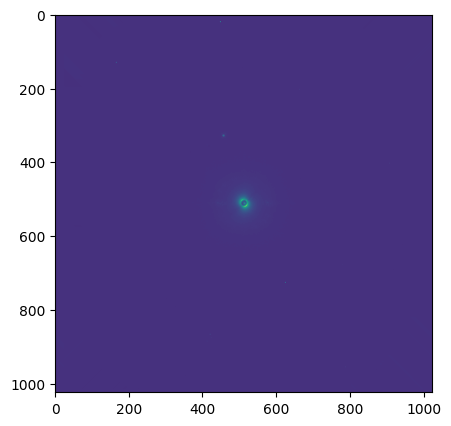

In [3]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(cube[0, 0])

In [4]:
def modify_shape_and_center(img, shift_h=1, shift_w=1):
    # Get the height and width of the image
    height, width = img.shape[:2]

    # Increase the image size by 1 pixel
    new_height = height + shift_h
    new_width = width + shift_w

    # Create a new image with the increased size
    new_img = np.zeros((new_height, new_width))

    # Calculate the offset needed to center the original image in the new image
    x_offset = int((new_width - width) / 2)
    y_offset = int((new_height - height) / 2)

    # Copy the original image into the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

In [5]:
psf_even = []
for curr_psf in psf[lambda_ch]:
    psf_even.append(modify_shape_and_center(curr_psf, shift_h=1, shift_w=1)) 
psf_even = np.array(psf_even)

Text(0.5, 1.0, '(3, 65, 65)')

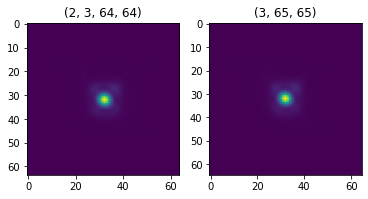

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(psf[lambda_ch, 0])
axes[0].set_title(psf.shape)

im = axes[1].imshow(psf_even[0])
axes[1].set_title(psf_even.shape)

## Normalize PSF

In [7]:
import vip_hci as vip

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-05 14:30:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 8 pixels
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.443975
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


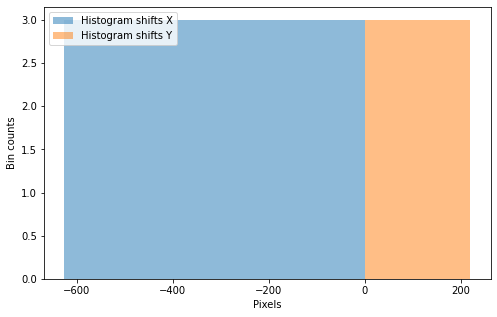

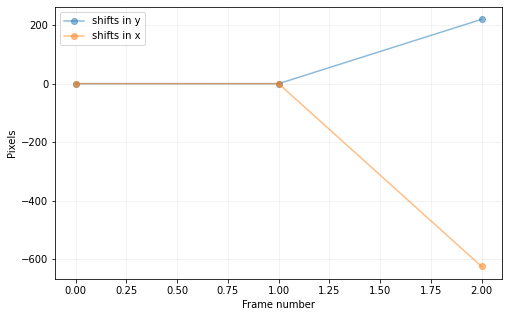

In [8]:
single_psf = psf[lambda_ch, psf_pos, :-1, :-1]
ceny, cenx = frame_center(single_psf)
imside = single_psf.shape[0]
cropsize = 30

fit = vip.var.fit_2dgaussian(single_psf, 
                             crop=True, 
                             cropsize=30, 
                             debug=False, 
                             full_output=True) 
fwhm_sphere = np.mean([fit.fwhm_y,fit.fwhm_x]) 

y_cent, x_cent = frame_center(single_psf) 
y_c=int(y_cent)
x_c=int(x_cent)
psf_center, y0_sh, x0_sh = vip.preproc.recentering.cube_recenter_2dfit(psf[lambda_ch], (y_c, x_c), 
                                                                       fwhm_sphere,model='gauss',
                                                                       nproc=8, subi_size=7, negative=False,
                                                                       full_output=False, 
                                                                       debug=False)

In [9]:
psf_norm, fwhm_flux,fwhm = normalize_psf(psf_center, 
                                         fwhm=fwhm_sphere, 
                                         size=None, 
                                         threshold=None, 
                                         mask_core=None,
                                         full_output=True, 
                                         verbose=True)  #psf normalizzata ad 1

`Force_odd` is True and frame size is even, therefore new frame size was set to 63
Flux in 1xFWHM aperture: 91267.747


## Angular Differential Imaging (ADI)

In [10]:
%%time
fr_pca = vip.psfsub.pca(cube[0], 
                            rot_ang,
                            svd_mode='eigencupy', 
                            full_output=False,
                            imlib='opencv') #pca image of the system

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-05 14:30:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.406 GB
System available memory = 226.637 GB
Done vectorizing the frames. Matrix shape: (80, 1048576)
Done PCA with cupy eigh function (GPU)
Running time:  0:00:14.764613
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:44.653521
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
CPU times: user 47.7 s, sys: 3 s, total: 50.7 s
Wall time: 44.7 s


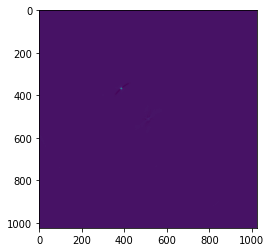

In [11]:
plt.imshow(fr_pca)

## Detection

In [12]:
res = vip.metrics.detection(fr_pca, fwhm=fwhm, psf=psf_norm, bkg_sigma=5, snr_thresh=5, 
                            debug=False, plot=False, verbose=True, full_output=True)

Blobs found: 9
 ycen   xcen
------ ------
367.857 	 385.836
511.953 	 519.166
504.432 	 521.179
507.957 	 502.530
519.285 	 503.017
521.467 	 524.557
399.929 	 299.975
732.760 	 549.484
541.256 	 524.970

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (385.8,367.9)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 385.8, 367.9
Flux in a centered 1xFWHM circular aperture = 315.378
Central pixel S/N = 66.342
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 50.439
Max S/N (shifting the aperture center) = 67.117
stddev S/N (shifting the aperture center) = 15.607


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (519.2,512.0)
S/N constraint NOT fulfilled (S/N = 3.810)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

In [13]:
res

,y,x,px_snr
0,367.857428,385.835709,66.341573
1,399.929333,299.975408,43.475600
2,732.759591,549.483627,24.162558


## Optimizing

In [31]:
%%time
results = vip.fm.negfc_simplex.firstguess(cube[0], 
                                          angs=rot_ang,       
                                          psfn=psf_norm, 
                                          ncomp=2, 
                                          planets_xy_coord=[(res.iloc[0]['y'], res.iloc[0]['x'])],
                                          imlib='opencv',
                                          fwhm=fwhm,
                                          simplex=True,
                                          annulus_width=4*fwhm,
                                          aperture_radius=2,
                                         algo_options={
                                             'nproc': 32,
                                             'imlib': 'opencv'
                                         })

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-08 13:39:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [367.85742795229544,385.83570898943134], running ...
Step | flux    | chi2r
1/30   0.100   2.771
2/30   0.149   2.775
3/30   0.221   2.781
4/30   0.329   2.789
Planet 0: preliminary position guess: (r, theta)=(191.6, 221.2)
Planet 0: preliminary flux guess: 0.1
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 197, nfev: 347, chi2r: 0.015265708969485375
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(191.774, 235.411, 99.251) at 
          (X,Y)=(403.13, 354.12)

 ―――――――――――――――――――

In [16]:
radius_fguess = results[0][0]
theta_fguess  = results[1][0]
flux_fguess   = results[2][0]

In [24]:
centy_fr, centx_fr = frame_center(cube[0])
posy = radius_fguess * np.sin(np.deg2rad(theta_fguess)) + centy_fr
posx = radius_fguess * np.cos(np.deg2rad(theta_fguess)) + centx_fr

(343.1316372238372, 463.1316372238372)

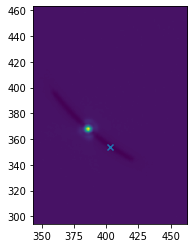

In [30]:
plt.figure()
plt.imshow(fr_pca)
plt.scatter(posx, posy, marker='x')
plt.ylim(posy-60, posx+60)
plt.xlim(posx-60, posx+60)